In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import clustering as clstr
import bout.assembly as bt
import plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
def plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    legend_patches = []
    for group in bout_params.keys():
        if group != 'site_key':
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'BCI = {round(bout_params[group], 2)}ms')
            legend_patches += [group_patch]

    dc_tag = data_params['cur_dc_tag']
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    time_on_in_mins = int(dc_tag.split('of')[0])
    data_params['index_time_block_in_secs'] = 5
    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
    windows = pd.date_range(file_dt, file_dt+pd.Timedelta(minutes=30), freq=f'{cycle_length_in_mins}T', inclusive='left')

    if not(plot_bouts.empty):
        plot_bout_info(ax, audio_features, plot_bouts)
        bout_duration_per_cycle = actvt.get_bout_duration_per_cycle(plot_bouts.copy(), cycle_length_in_mins)
        bout_duration_per_cycle = bout_duration_per_cycle.reindex(windows, fill_value=0)
        btp_per_cycle = actvt.get_btp_per_time_on(bout_duration_per_cycle, data_params['time_on_in_secs'])
        plot_recording_periods_with_btp(ax, audio_features, data_params, np.round(btp_per_cycle,2))
    if not(plot_dets.empty):
        num_dets_per_cycle = actvt.get_number_of_detections_per_cycle(plot_dets.copy(), cycle_length_in_mins)
        num_dets_per_cycle = num_dets_per_cycle.reindex(windows, fill_value=0)
        callrate_per_cycle = actvt.get_metric_per_time_on(num_dets_per_cycle, time_on_in_mins)
        plot_recording_periods_with_callrate(ax, audio_features, data_params, np.round(callrate_per_cycle,2))
        blocks_per_cycle = actvt.get_activity_index_per_cycle(plot_dets.copy(), data_params)
        blocks_per_cycle = blocks_per_cycle.reindex(windows, fill_value=0)
        inds_percent_per_cycle = actvt.get_activity_index_per_time_on_index(blocks_per_cycle, data_params)
        plot_activity_index_time_blocks(ax, audio_features, data_params)
        plot_recording_periods_with_activity_inds_percent(ax, audio_features, data_params, np.round(inds_percent_per_cycle,2))

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=len(legend_patches), loc=1)

    plt.tight_layout()
    plt.show()


def plot_recording_periods_with_callrate(ax, audio_features, data_params, callrate_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.15, s=f"{callrate_per_cycle[window_count]} calls/min", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.15, s=f"{callrate_per_cycle[window_count]} calls/min", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.15, s=f"{callrate_per_cycle[window_count]} calls/min", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_btp(ax, audio_features, data_params, btp_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.25, s=f"{btp_per_cycle[window_count]}% BTP", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.25, s=f"{btp_per_cycle[window_count]}% BTP", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor=None, alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.25, s=f"{btp_per_cycle[window_count]}% BTP", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)

def plot_recording_periods_with_activity_inds_percent(ax, audio_features, data_params, inds_per_cycle):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc = (min(time_on, ((window_start+time_on)-start)))/4
                plt.text(x=text_loc*fs/2, y=0.05, s=f"{inds_per_cycle[window_count]}% AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) +(min(time_on, (start+duration) - window_start)/4)
                plt.text(x=text_loc*fs/2, y=0.05, s=f"{inds_per_cycle[window_count]}% AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
                text_loc =  (window_start-start) + (time_on/4)
                plt.text(x=text_loc*fs/2, y=0.05, s=f"{inds_per_cycle[window_count]}% AI", color='pink', weight='bold', fontsize=14)
                window_count+=1
            ax.add_patch(rect)
            
def plot_bout_info(ax, audio_features, plot_bouts):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    for i, row in plot_bouts.iterrows():
        if duration < 600:
            plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+2000)/(fs/2), 9/10), 
                                s=f"{round(row['bout_duration_in_secs'], 2)}s", color='pink', weight='bold', fontsize=14)
            plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+12000)/(fs/2), 9/10), 
                                s=f"{round(row['number_of_dets'], 2)} dets", color='pink', weight='bold', fontsize=14)
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)

def plot_recording_periods(ax, audio_features, data_params):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    for window_start in window_starts:
        if (window_start <= start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.1)
            ax.add_patch(rect)

def plot_activity_index_time_blocks(ax, audio_features, data_params):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']
    index_time_block = data_params['index_time_block_in_secs']

    cycle_length = index_time_block
    time_on = index_time_block

    window_starts = np.arange(0, 1800, cycle_length)
    window_count = 0
    for window_start in window_starts:
        if (window_start < start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='pink', facecolor=None, alpha=0.1)
                window_count+=1
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='pink', facecolor=None, alpha=0.1)
                window_count+=1
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='pink', facecolor=None, alpha=0.1)
                window_count+=1
            ax.add_patch(rect)

In [13]:
site_key = 'Telephone'
freq_key = ''

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)

In [14]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
single_night_files = files_from_loc[:21]
single_night_files

[PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_073000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220822/Telephone/20220820_080000.WAV'),

In [15]:
bout_metrics = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, bout_params)

In [16]:
bout_metrics

start_time_of_bout           end_time_of_bout  start_time_wrt_ref  \
0   2022-07-23 04:28:54.890500 2022-07-23 04:29:04.165100           1734.8905   
1   2022-07-23 04:30:11.839500 2022-07-23 04:30:14.868800             11.8395   
2   2022-07-23 04:32:11.407500 2022-07-23 04:32:18.033600            131.4075   
3   2022-07-23 04:32:25.987500 2022-07-23 04:32:29.817600            145.9875   
4   2022-07-23 04:32:31.958500 2022-07-23 04:32:33.575300            151.9585   
..                         ...                        ...                 ...   
973 2022-10-17 07:39:00.033500 2022-10-17 07:39:04.271300            540.0335   
974 2022-10-17 07:39:15.192500 2022-10-17 07:39:15.497400            555.1925   
975 2022-10-17 07:39:24.389500 2022-10-17 07:39:24.756700            564.3895   
976 2022-10-17 07:39:52.626500 2022-10-17 07:39:54.000000            592.6265   
977 2022-10-17 13:49:59.893500 2022-10-17 13:50:00.747700           1199.8935   

     end_time_wrt_ref  start_time   end_time  low_freq  high_freq freq_group  \
0           1744.1651   1734.8905  1744.1651   41796.0    64800.0         HF   
1             14.8688     11.8395    14.8688   35781.0    70180.0         HF   
2            138.0336    131.4075   138.0336   39218.0    63030.0         HF   
3            149.8176    145.9875   149.8176   38359.0    59686.0         HF   
4            153.5753    151.9585   153.5753   40078.0    56466.0         HF   
..                ...         ...        ...       ...        ...        ...   
973          544.2713    540.0335   544.2713   25468.0    40890.0         LF   
974          555.4974    555.1925   555.4974   27187.0    37005.0         LF   
975          564.7567    564.3895   564.7567   28046.0    37560.0         LF   
976          594.0000    592.6265   594.0000   28046.0    36865.0         LF   
977         1200.7477   1199.8935  1200.7477   22031.0    28742.0         LF   

    cycle_ref_time_start  cycle_ref_time_end  number_of_dets  \
0    2022-07-23 04:00:00 2022-07-23 04:00:00              53   
1    2022-07-23 04:30:00 2022-07-23 04:30:00              21   
2    2022-07-23 04:30:00 2022-07-23 04:30:00              38   
3    2022-07-23 04:30:00 2022-07-23 04:30:00              33   
4    2022-07-23 04:30:00 2022-07-23 04:30:00              12   
..                   ...                 ...             ...   
973  2022-10-17 07:30:00 2022-10-17 07:30:00              21   
974  2022-10-17 07:30:00 2022-10-17 07:30:00               2   
975  2022-10-17 07:30:00 2022-10-17 07:30:00               3   
976  2022-10-17 07:30:00 2022-10-17 07:30:00              10   
977  2022-10-17 13:30:00 2022-10-17 13:30:00               3   

             bout_duration  bout_duration_in_secs  
0   0 days 00:00:09.274600                 9.2746  
1   0 days 00:00:03.029300                 3.0293  
2   0 days 00:00:06.626100                 6.6261  
3   0 days 00:00:03.830100                 3.8301  
4   0 days 00:00:01.616800                 1.6168  
..                     ...                    ...  
973 0 days 00:00:04.237800                 4.2378  
974 0 days 00:00:00.304900                 0.3049  
975 0 days 00:00:00.367200                 0.3672  
976 0 days 00:00:01.373500                 1.3735  
977 0 days 00:00:00.854200                 0.8542  

[28968 rows x 14 columns]

In [17]:
sample_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time_of_bout'] >= dt.datetime(2022,8,20,3,0,0), bout_metrics['end_time_of_bout'] <= dt.datetime(2022,8,20,13,30,0))]

In [18]:
sample_bouts

start_time_of_bout           end_time_of_bout  \
3292 2022-08-20 03:44:24.881500 2022-08-20 03:44:32.409700   
3293 2022-08-20 03:44:34.189500 2022-08-20 03:44:34.558100   
3294 2022-08-20 03:44:40.308500 2022-08-20 03:44:41.789600   
3295 2022-08-20 03:44:43.854500 2022-08-20 03:44:51.493800   
3296 2022-08-20 03:44:56.407500 2022-08-20 03:45:11.435200   
...                         ...                        ...   
160  2022-08-20 09:29:40.779500 2022-08-20 09:29:44.076900   
161  2022-08-20 10:08:11.808500 2022-08-20 10:08:12.030700   
162  2022-08-20 11:35:55.627500 2022-08-20 11:35:57.030000   
163  2022-08-20 12:29:28.230500 2022-08-20 12:29:28.305800   
164  2022-08-20 12:34:00.073500 2022-08-20 12:34:01.231800   

      start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
3292            864.8815          872.4097    864.8815   872.4097   29765.0   
3293            874.1895          874.5581    874.1895   874.5581   38359.0   
3294            880.3085          881.7896    880.3085   881.7896   40078.0   
3295            883.8545          891.4938    883.8545   891.4938   28046.0   
3296            896.4075          911.4352    896.4075   911.4352   28906.0   
...                  ...               ...         ...        ...       ...   
160            1780.7795         1784.0769   1780.7795  1784.0769   22890.0   
161             491.8085          492.0307    491.8085   492.0307   29765.0   
162             355.6275          357.0300    355.6275   357.0300   26328.0   
163            1768.2305         1768.3058   1768.2305  1768.3058   19453.0   
164             240.0735          241.2318    240.0735   241.2318   20312.0   

      high_freq freq_group cycle_ref_time_start  cycle_ref_time_end  \
3292    86330.0         HF  2022-08-20 03:30:00 2022-08-20 03:30:00   
3293    49331.0         HF  2022-08-20 03:30:00 2022-08-20 03:30:00   
3294    50655.0         HF  2022-08-20 03:30:00 2022-08-20 03:30:00   
3295    88431.0         HF  2022-08-20 03:30:00 2022-08-20 03:30:00   
3296    88244.0         HF  2022-08-20 03:30:00 2022-08-20 03:30:00   
...         ...        ...                  ...                 ...   
160     41998.0         LF  2022-08-20 09:00:00 2022-08-20 09:00:00   
161     41046.0         LF  2022-08-20 10:00:00 2022-08-20 10:00:00   
162     40714.0         LF  2022-08-20 11:30:00 2022-08-20 11:30:00   
163     38594.0         LF  2022-08-20 12:00:00 2022-08-20 12:00:00   
164     34978.0         LF  2022-08-20 12:30:00 2022-08-20 12:30:00   

      number_of_dets          bout_duration  bout_duration_in_secs  
3292              37 0 days 00:00:07.528200                 7.5282  
3293               2 0 days 00:00:00.368600                 0.3686  
3294               3 0 days 00:00:01.481100                 1.4811  
3295              40 0 days 00:00:07.639300                 7.6393  
3296              62 0 days 00:00:15.027700                15.0277  
...              ...                    ...                    ...  
160               22 0 days 00:00:03.297400                 3.2974  
161                2 0 days 00:00:00.222200                 0.2222  
162                6 0 days 00:00:01.402500                 1.4025  
163                2 0 days 00:00:00.075300                 0.0753  
164                3 0 days 00:00:01.158300                 1.1583  

[1638 rows x 14 columns]

In [19]:
def get_between_bout_intervals_in_secs(bout_metrics):
    
    intervals = bout_metrics['start_time_of_bout'] - bout_metrics['end_time_of_bout'].shift(1)
    bout_metrics.insert(0, 'between_bout_intervals', intervals)
    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bm_LF_df = bout_metrics.set_index('ref_time')
    first_calls_per_day = bm_LF_df.resample('D').first()['start_time_of_bout']
    first_valid_calls_per_day = pd.DatetimeIndex(first_calls_per_day.loc[~first_calls_per_day.isna()].values)
    bm_LF_df.loc[first_valid_calls_per_day, 'between_bout_intervals'] = pd.NaT
    intervals = bm_LF_df['between_bout_intervals'].values
    valid_intervals = intervals[~np.isnan(intervals)]
    ipis_s = valid_intervals.astype('float32')/1e9

    return ipis_s

In [20]:
bout_metrics_LF = sample_bouts[sample_bouts['freq_group']=='LF'].copy()
bout_metrics_HF = sample_bouts[sample_bouts['freq_group']=='HF'].copy()

ipis_s_lf = get_between_bout_intervals_in_secs(bout_metrics_LF)
ipis_s_hf = get_between_bout_intervals_in_secs(bout_metrics_HF)
lf_bci = bout_params['LF_bci']
hf_bci = bout_params['HF_bci']

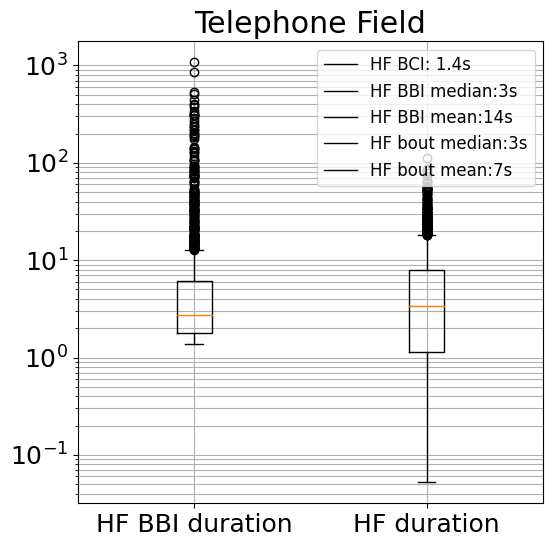

In [25]:
labels = [f'HF BCI: {round(hf_bci/1000, 1)}s',
        f'HF BBI median:{round(np.median(ipis_s_hf))}s',
        f'HF BBI mean:{round(np.mean(ipis_s_hf))}s',
        f'HF bout median:{round(bout_metrics_HF["bout_duration_in_secs"].median())}s',
        f'HF bout mean:{round(bout_metrics_HF["bout_duration_in_secs"].mean())}s']

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':18})
plt.title(f'{SITE_NAMES[site_key]}')
plt.boxplot([ipis_s_hf, bout_metrics_HF['bout_duration_in_secs']])
plt.xticks([1, 2], ['HF BBI duration', 'HF duration'])
plt.yscale('log')
plt.legend(labels, fontsize=12, loc=1)
plt.grid(which='both')

plt.show()

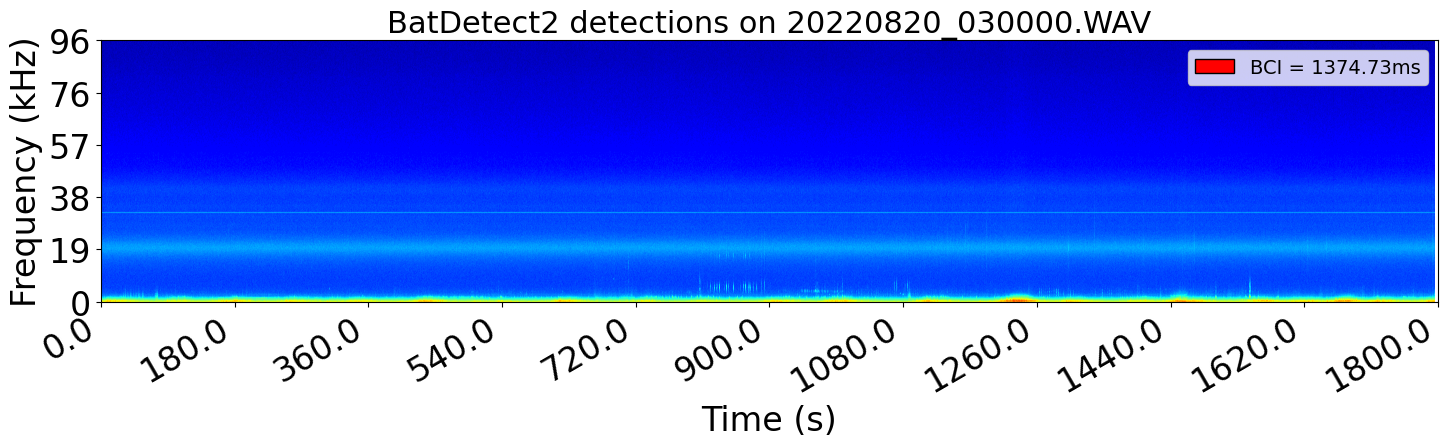

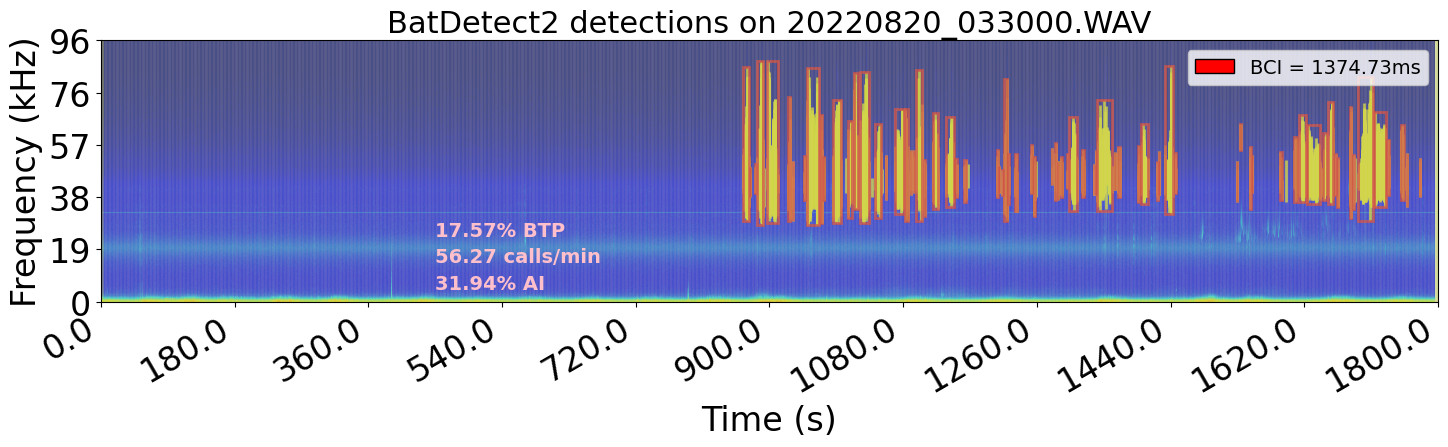

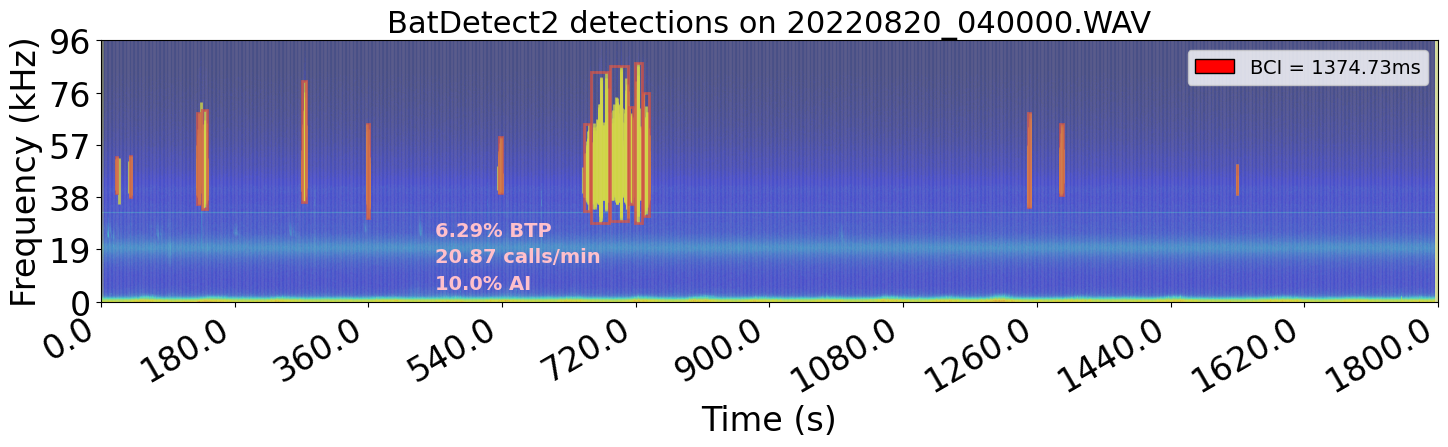

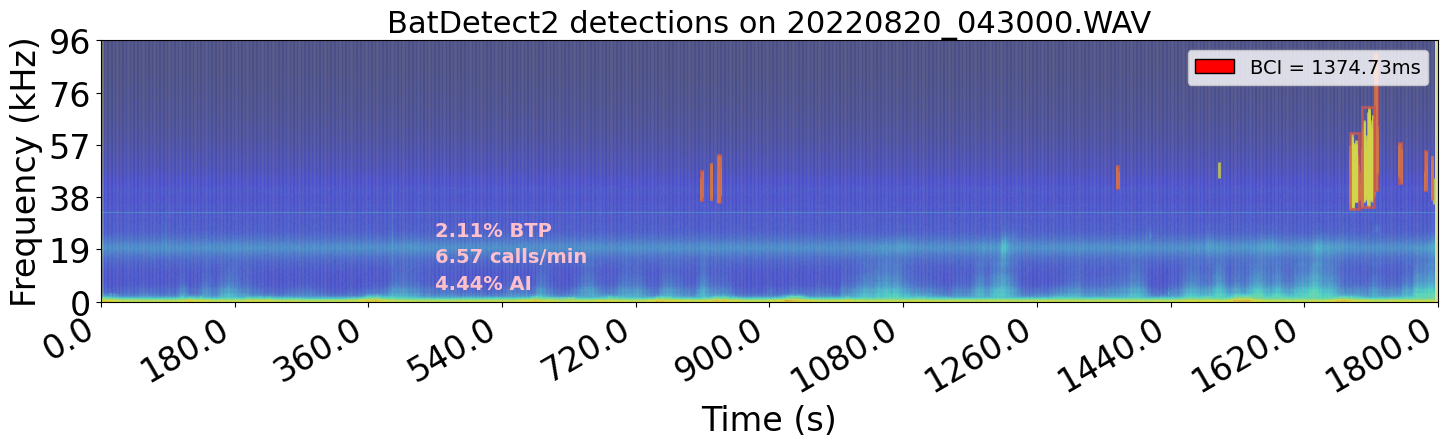

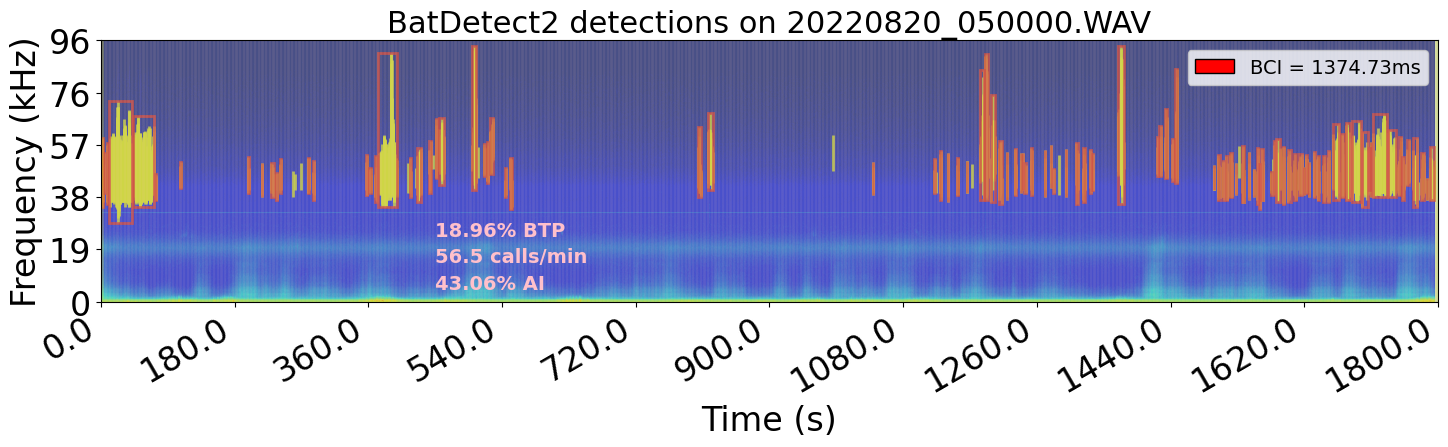

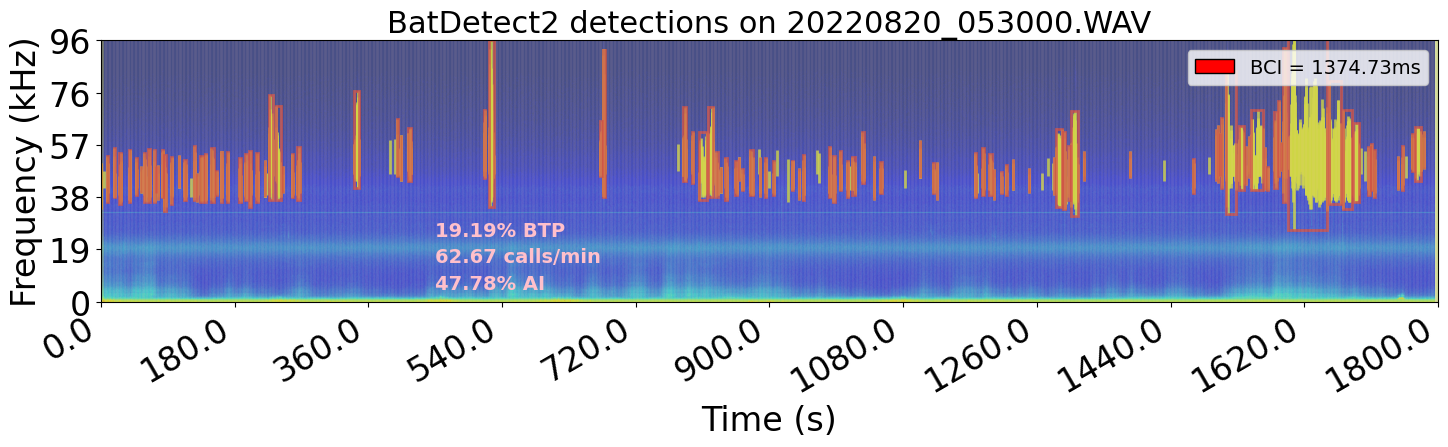

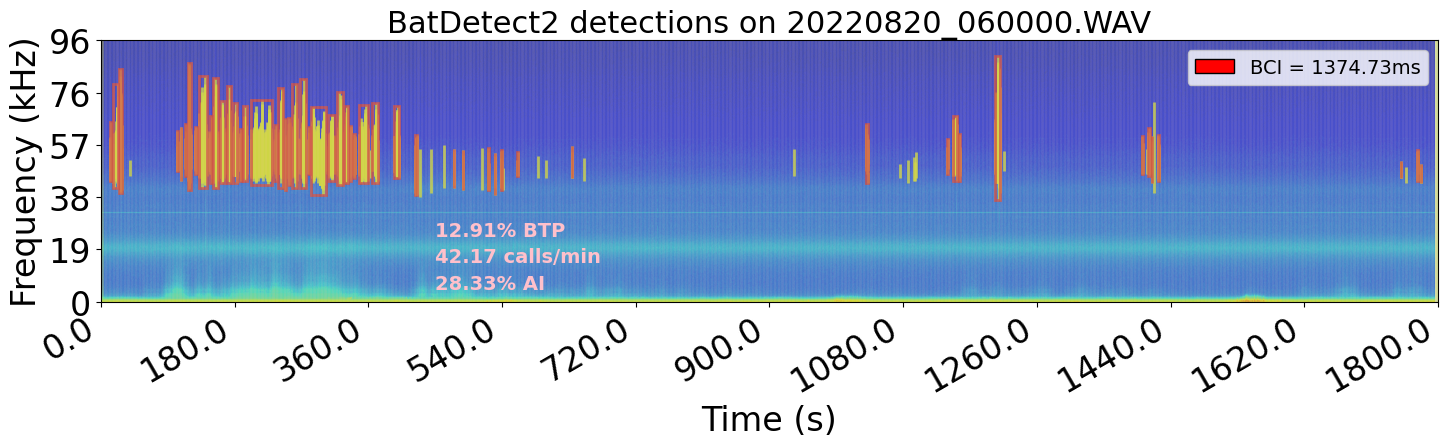

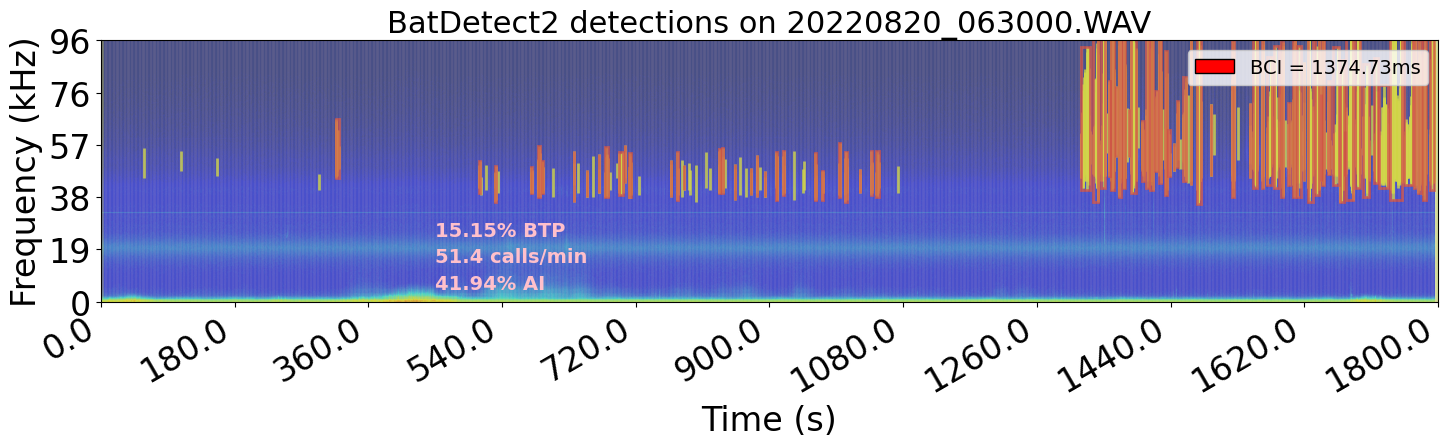

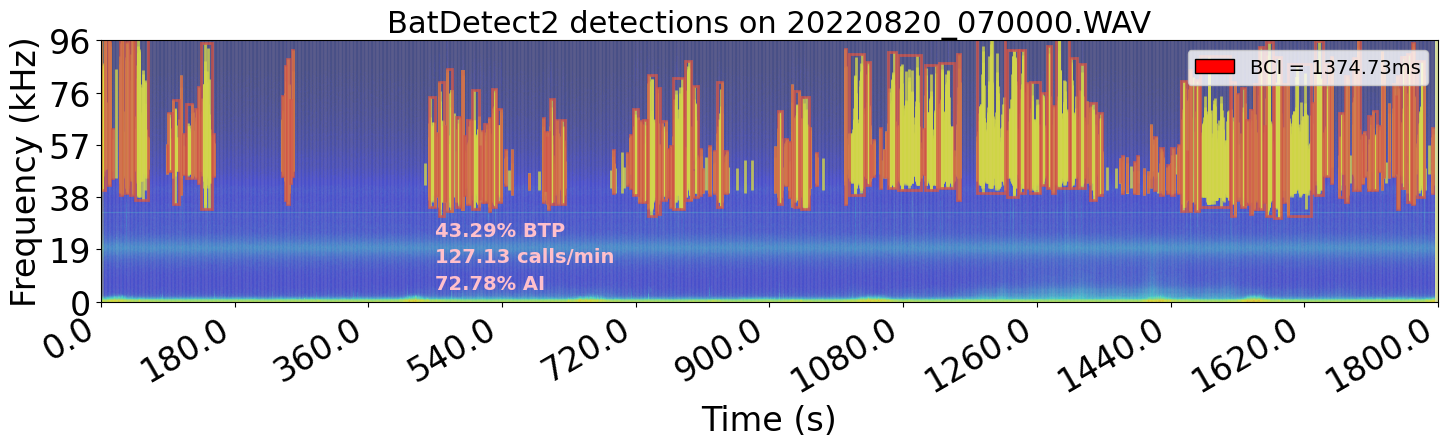

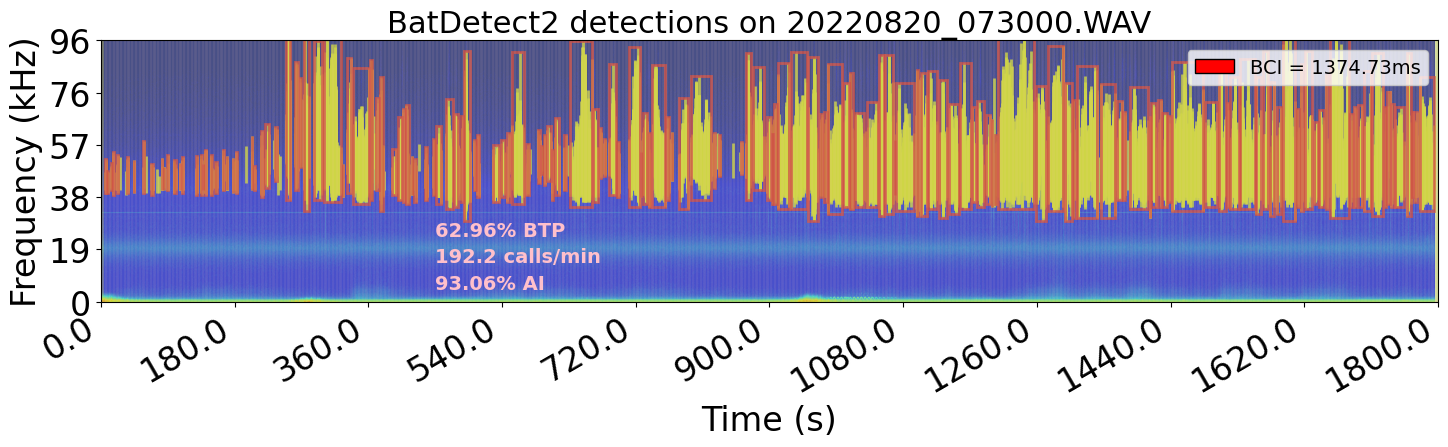

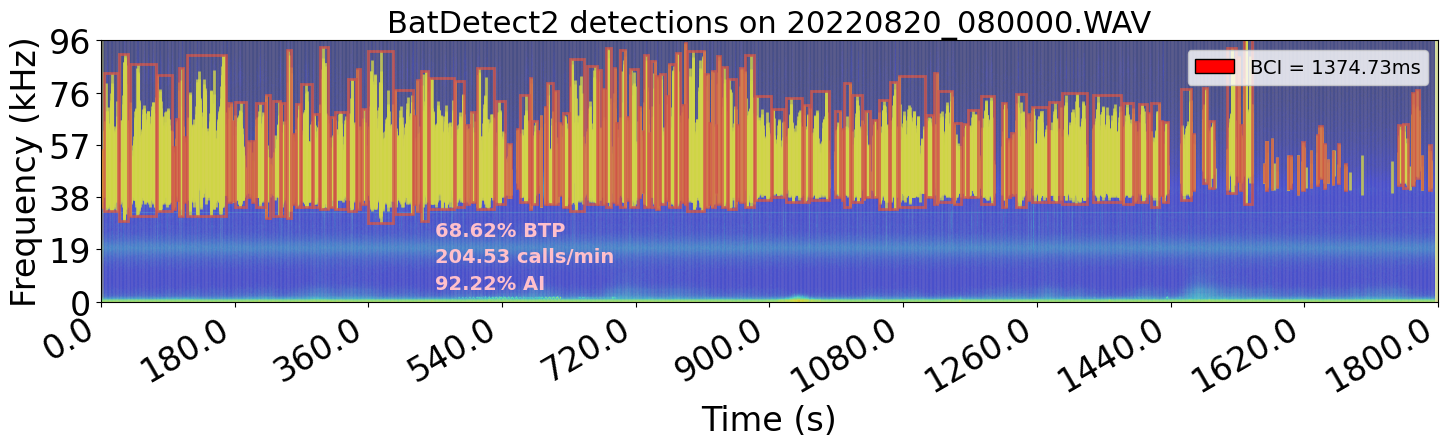

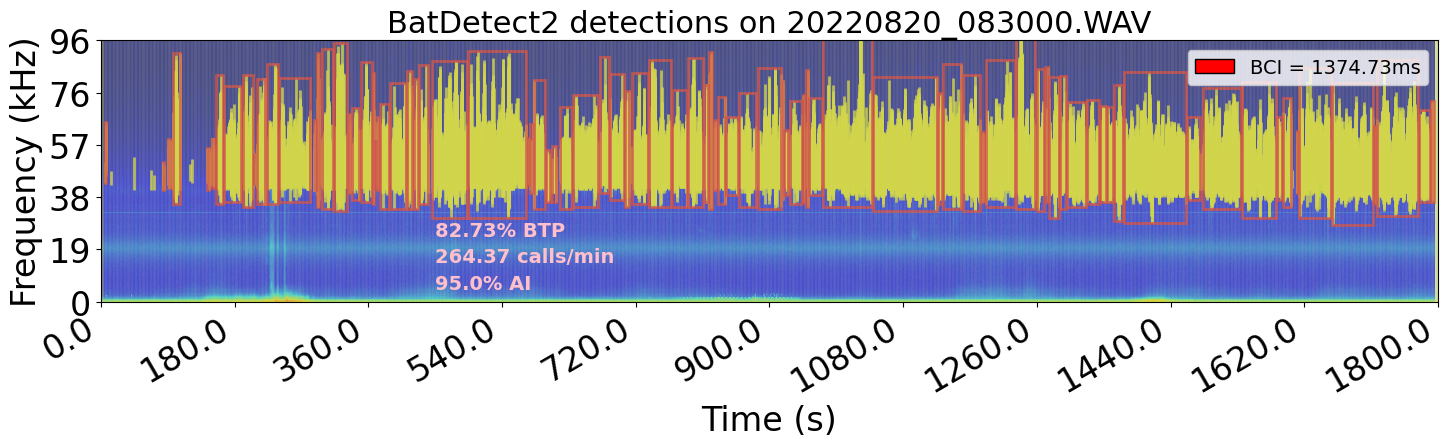

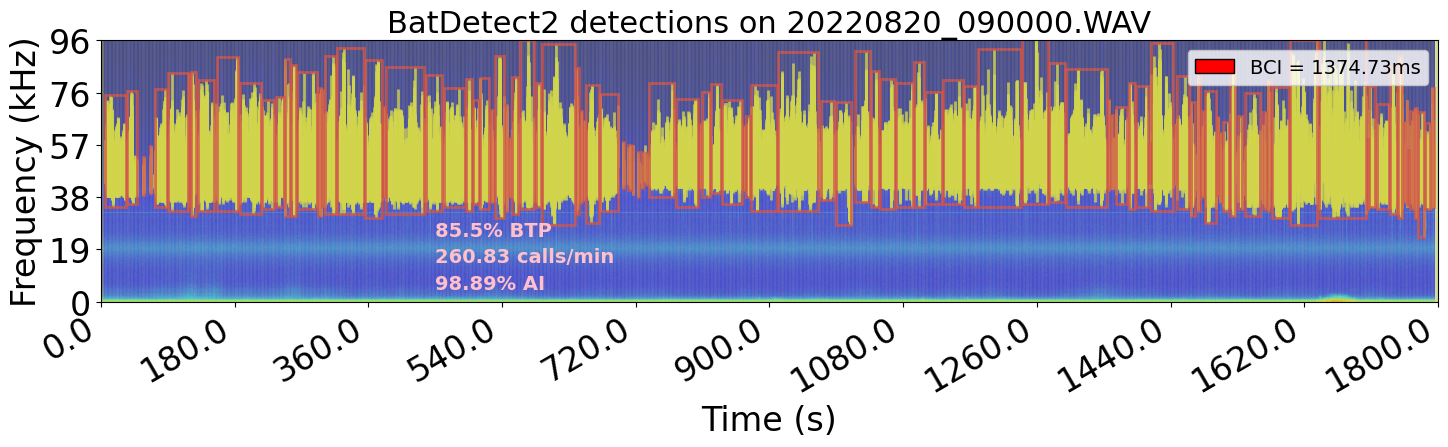

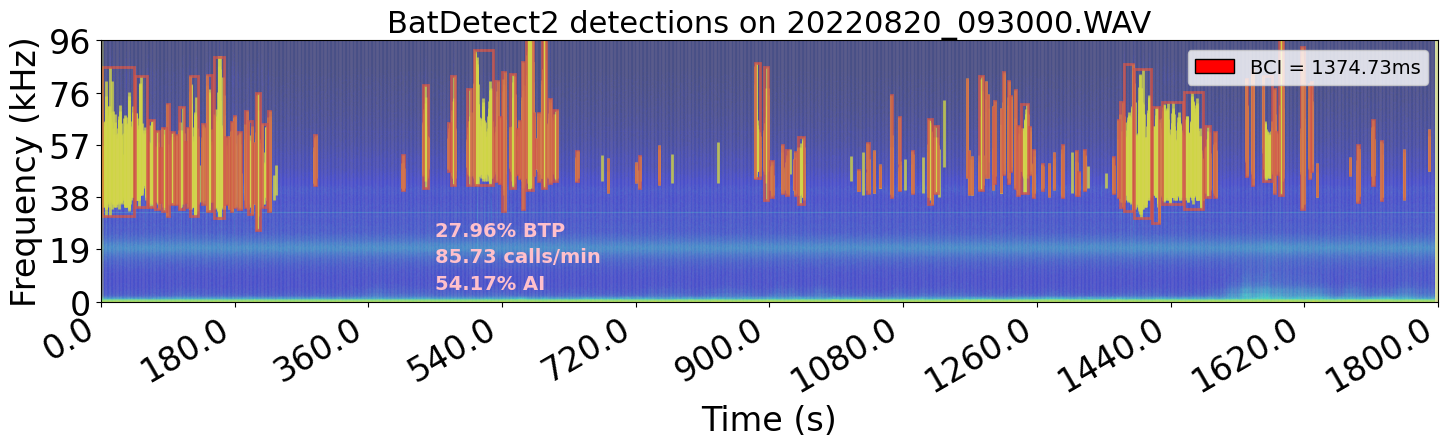

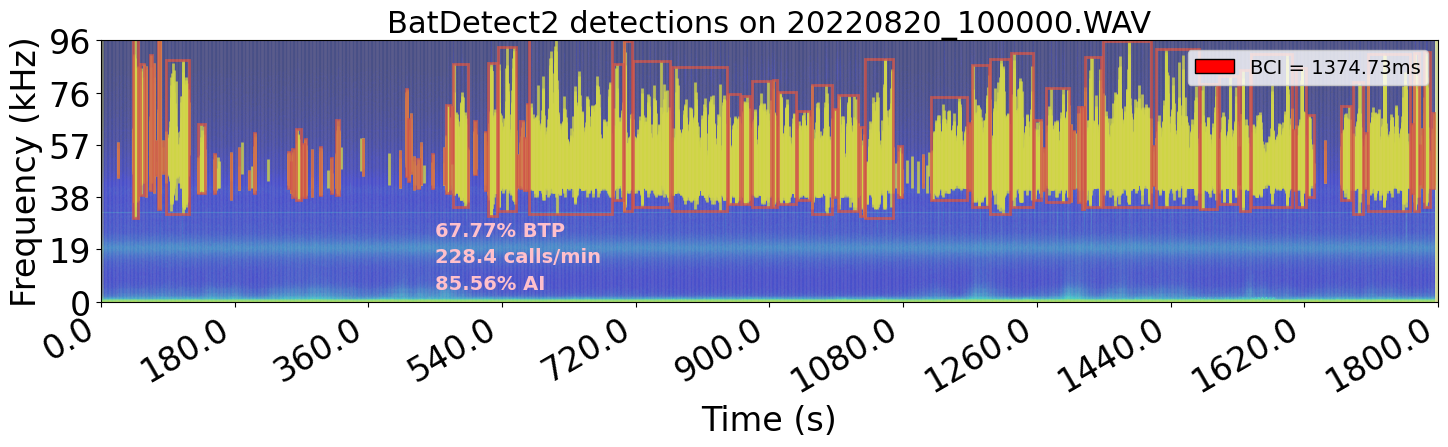

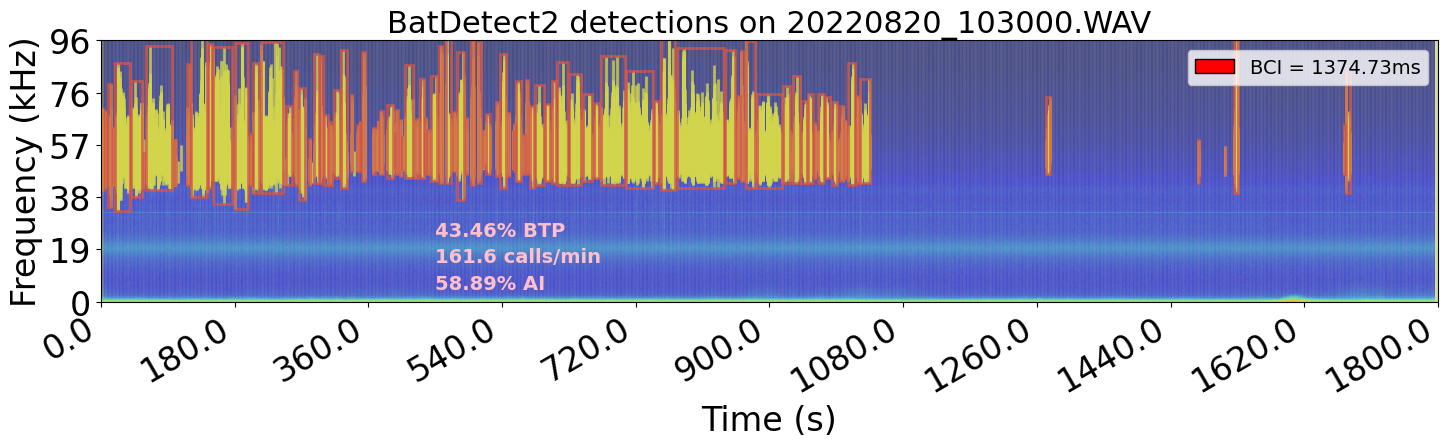

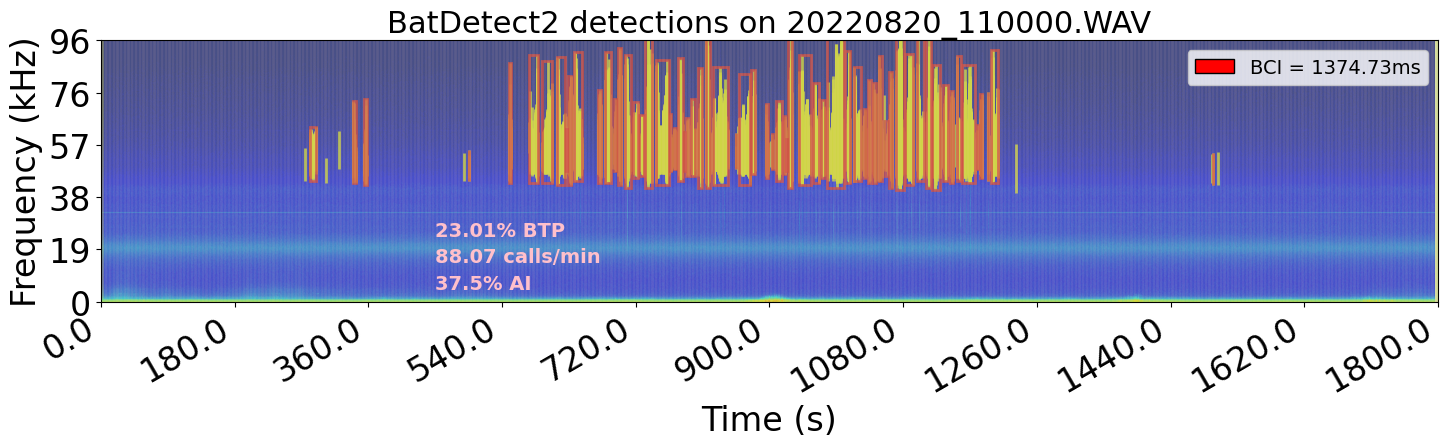

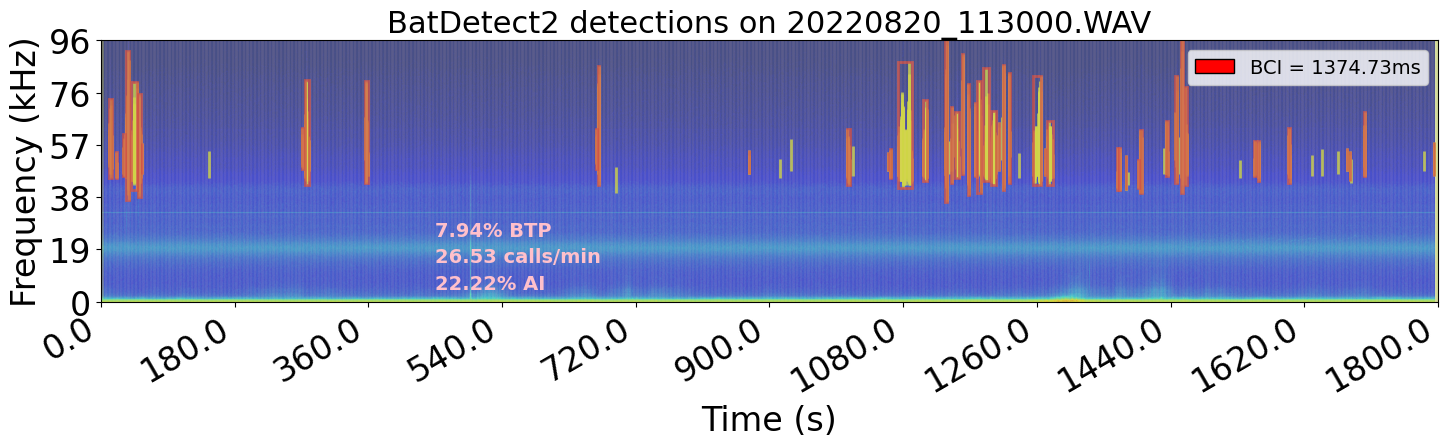

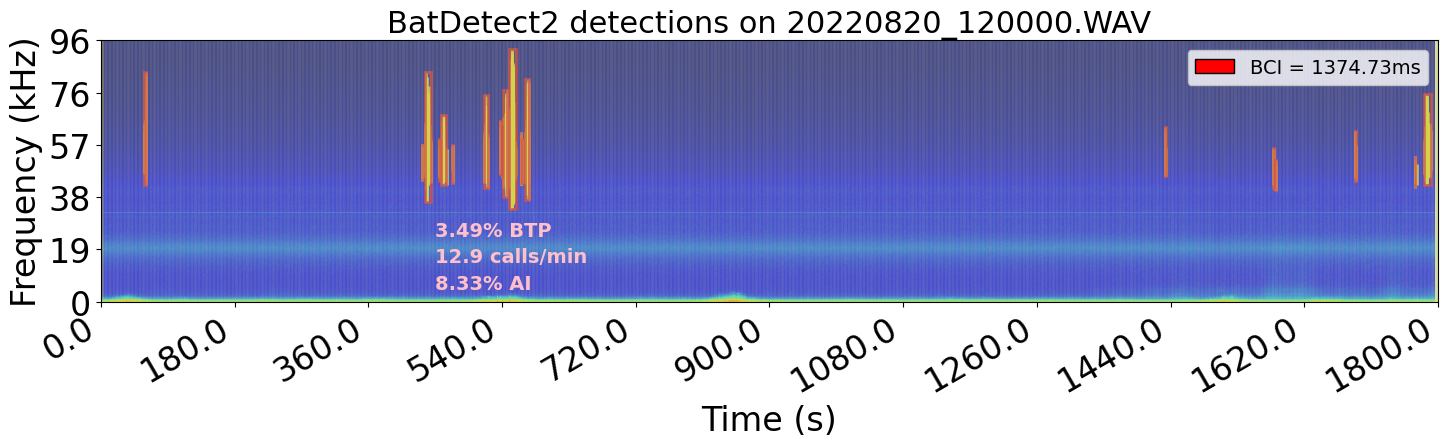

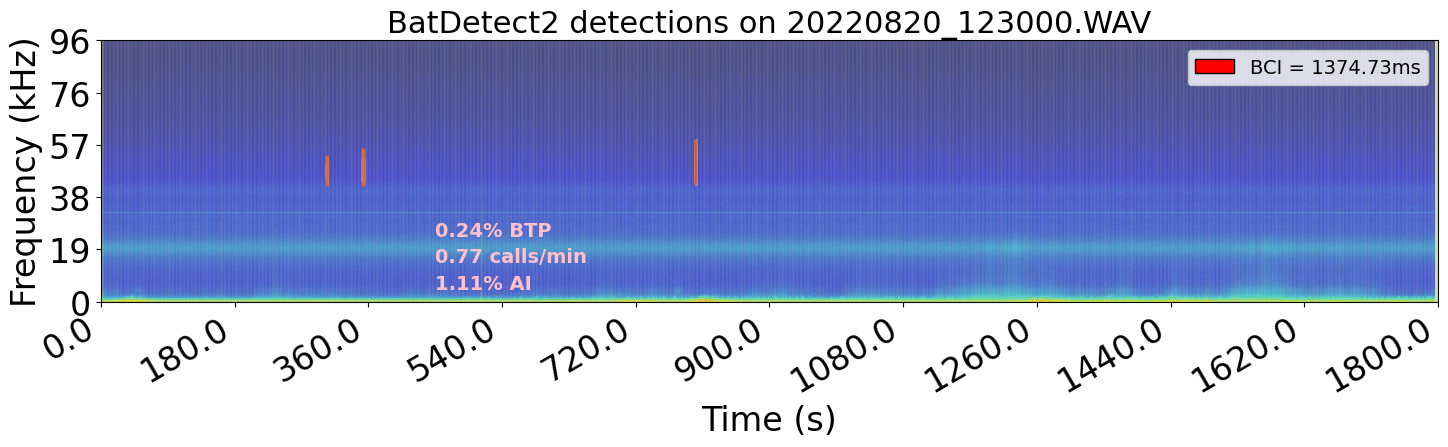

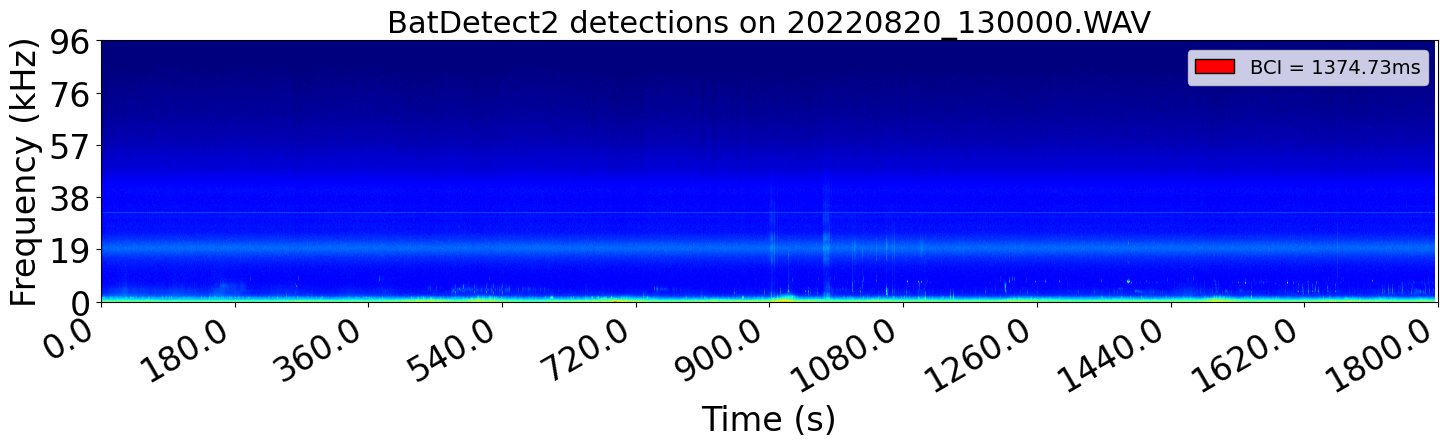

In [7]:
for file in single_night_files:
    file_path = Path(file)
    filename = file_path.name
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate
    start = 0
    duration = 1800
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration

    spec_features = dict()
    spec_features['vmin'] = vmin
    spec_features['NFFT'] = 1024
    spec_features['cmap'] = 'jet'

    file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
    file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

    plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
    plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]
    if not(plot_dets.empty):
        bout_metrics = bt.generate_bout_metrics_for_location_and_freq(plot_dets, data_params, bout_params)
        plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] >= start, bout_metrics['end_time'] <= (start+duration))]
    else:
        plot_bouts = pd.DataFrame()
    # plot_raw_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)
    plot_normalized_metrics_over_audio_seg(audio_features, spec_features, plot_dets, plot_bouts, bout_params,  data_params)